In [133]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import os
dir_path = os.getcwd()


In [134]:
d_types = ['data', 'test']
data = dict()
for d_type in d_types:
        path = dir_path +"/"+"classification_data_HWK2/EMGaussian." + d_type 
        data[d_type] = pd.read_csv(path, sep=' ', header=None).values

In [135]:
Y_t_data = data['data']
K = 4
T = len(Y_t_data) - 1

In [136]:
# We use the parameters found in HW2 - Q3 (We use our data)
pi = [0.20, 0.24, 0.25, 0.31]
centers = [[3.79, -3.64], [ 3.99, -3.64 ], [ -2.03, 4.16 ], [ -3.08, -3.56 ]]

sigma_0 = np.matrix([[ 0.87, 0.06 ], [ 0.06, 2.21]])
sigma_1 = np.matrix([[ 0.20, 0.22 ], [ 0.22, 10.40]])
sigma_2 = np.matrix([[ 2.92, 0.17 ], [ 0.17, 2.77]])
sigma_3 = np.matrix([[ 6.14, 5.94 ], [ 5.94, 6.07]])

sigmas = [sigma_0, sigma_1, sigma_2, sigma_3]

multivar = dict()
for k in range(K):
    m = scipy.stats.multivariate_normal(centers[k], sigmas[k])
    multivar[k] =m
    
# We also need to initiate A as it is not specified what is its value
# We follow Mr Chopin's advice to have strong weight on the diagonal
A =  1/10 * np.ones((K,K)) + 6/10 * np.identity(K)

In [137]:
def computeAlpha(z, Y_t_data, A,  t): 
    if t == 0:
        return pi[z]
    p_yt_zt = multivar[z].pdf(Y_t_data[t])
    alpha = 0
    for i in range(K):
        alpha += p_yt_zt * A[z, i] * computeAlpha(i, Y_t_data, A, t-1)
        
    return alpha

In [138]:
print(computeAlpha(2, Y_t_data, A, 8))
print(np.log(computeAlpha(2, Y_t_data, A, 8)))

9.711462643780658e-22
-48.38356514218259


In [139]:
def computeBeta(z, Y_t_data, A,  t): 
    if t == T:
        return 1
    beta = 0
    for i in range(K):
        beta += A[z, i] * multivar[i].pdf(Y_t_data[t]) *  computeBeta(i, Y_t_data, A, t+1)
    return beta

In [140]:
print(computeBeta(2, Y_t_data, A, T-3))
print(np.log(computeBeta(2, Y_t_data, A, T-3)))

4.810772938040479e-07
-14.547237885771235


#### we note that values are very low, we thus need to use the log version to prevent numerical errors
#### we will use the log-sum-exp trick to solve it more easily https://www.xarg.org/2016/06/the-log-sum-exp-trick-in-machine-learning/

#### We will also use a matrix to store the already computed values of logAlpha and logBeta to prevent us from recomputing the whole recursivity at every step

In [141]:
# we note that values are very low, we thus need to use the log version to prevent numerical errors
log_A = np.log(A)
log_pi = np.log(pi)

# We will also use a matrix to store the already computed values of logAlpha and logBeta to prevent us from recomputing
# the whole recursivity at every step


In [142]:
def computeLogAlpha(z, Y_t_data, log_A, log_pi, memory_log_alpha, multivar,  t): 
    if t == 0:
        memory_log_alpha[z, t] = log_pi[z]
        return log_pi[z]
    p_yt_zt = multivar[z].pdf(Y_t_data[t])
    log_alpha = 0
    log_inside_sum = [0,0,0,0]
    for i in range(K):
        log_alpha_i_tminus1 = 0 
        if memory_log_alpha[i, t-1] == 0:
            log_alpha_i_tminus1 = computeLogAlpha(i, Y_t_data, log_A, log_pi, memory_log_alpha,multivar,  t-1)
        else:
            log_alpha_i_tminus1 = memory_log_alpha[i, t-1]
        log_inside_sum[i] = log_alpha_i_tminus1 + log_A[z, i]
        
    max_log = np.max(log_inside_sum)
    
    log_alpha += np.log(p_yt_zt) + max_log + np.log(np.sum(np.exp(log_inside_sum - max_log)))
    
    memory_log_alpha[z, t] = log_alpha  
    return log_alpha

In [143]:
memory_log_alpha = np.zeros((K, T + 1))
computeLogAlpha(2, Y_t_data, log_A, log_pi, memory_log_alpha,multivar,  8)

-48.38356514218258

In [144]:
def computeLogBeta(z, Y_t_data, log_A, memory_log_beta, multivar,  t): 
    if t == T:  
        memory_log_beta[z, t] = 0
        return 0
    log_inside_sum = [0,0,0,0]
    for i in range(K):
        log_beta_i_tplus1 = 0 
        if memory_log_beta[i, t+1] == 0:
            log_beta_i_tplus1 = computeLogBeta(i, Y_t_data, log_A, memory_log_beta, multivar, t+1)
        else:
            log_beta_i_tplus1 = memory_log_beta[i, t+1]
        log_inside_sum[i] = log_A[z, i] + np.log(multivar[i].pdf(Y_t_data[t])) +  log_beta_i_tplus1
    
    max_log = np.max(log_inside_sum)
    log_beta = max_log + np.log(np.sum(np.exp(log_inside_sum - max_log)))  
    memory_log_beta[z, t] = log_beta  
    return log_beta

In [145]:
memory_log_beta = np.zeros((K, T + 1))
print(computeLogBeta(2, Y_t_data, log_A, memory_log_beta, multivar, T-3))

-14.547237885771237


## 3. EM Algorithm

We will use the formulas found computed on the pdf file 
We will also initialize $\Pi_0$, $\mu_i$ and $\Sigma_i$ with the values found in the previous homework

For A, we will follow Mr Chopin's advice and we'll initiate our matrix with strong diagonal weights

In [177]:
def computeSmoothing(memory_log_alpha, memory_log_beta):
    p_zt_i = np.zeros((K, T+1))
    for t in range(T+1):
        memory_log_alpha_t = memory_log_alpha[:, t]
        memory_log_beta_t = memory_log_alpha[:, t]
        sum_memory_log_t = memory_log_alpha_t + memory_log_beta_t
        max_sum_log = np.min(-sum_memory_log_t)
        augmented_exp_sum_memory_log_t = np.exp(sum_memory_log_t + max_sum_log)
        for i in range(K):
            p_zt_i[i, t] = augmented_exp_sum_memory_log_t[i] / np.sum(augmented_exp_sum_memory_log_t)
            
    
            
    return p_zt_i

def compute_log_smoothing2(log_alpha, log_beta):
    assert(len(log_alpha) == len(log_beta))
    K, T = log_alpha.shape
    print(T, K)
    
    log_smoothing = log_alpha + log_beta
    
    tmp = log_alpha + log_beta
    max_tmp = np.max(tmp)
    log_evidence = max_tmp + np.log(np.sum(np.exp(tmp - max_tmp)))
    
    res = log_smoothing - log_evidence
    #assert ((check_sums(res) - 1.) < 1e-6).all()
    return np.exp(res)

def computePijt(memory_log_alpha, memory_log_beta, log_A, multivar, Y_t_data):
    pijt = np.zeros((K,K, T+1))

    for t in range(T):
        sum_memory_log_t = memory_log_alpha[:, t] + memory_log_beta[:, t]

        max_sum_memory_log_t = np.max(sum_memory_log_t)
        log_denominator = max_sum_memory_log_t + np.log(np.sum(np.exp(sum_memory_log_t - max_sum_memory_log_t)))

        tot = 0
        
        for i in range(K):
            for j in range(K):
                log_numerator = memory_log_alpha[:, t][i] + memory_log_beta[:, t+1][j] + log_A[i,j] + np.log(multivar[j].pdf(Y_t_data[t]))
                value = np.exp(log_numerator - log_denominator)
                pijt[i, j, t] = value
                tot+=value
    return pijt

In [178]:
def EM(niter):
    Y_t_data = data['data']
    
    # init
    pi = [0.20, 0.24, 0.25, 0.31]
    centers = np.array([[3.79, -3.64], [ 3.99, -3.64 ], [ -2.03, 4.16 ], [ -3.08, -3.56 ]])

    sigma_0 = np.matrix([[ 0.87, 0.06 ], [ 0.06, 2.21]])
    sigma_1 = np.matrix([[ 0.20, 0.22 ], [ 0.22, 10.40]])
    sigma_2 = np.matrix([[ 2.92, 0.17 ], [ 0.17, 2.77]])
    sigma_3 = np.matrix([[ 6.14, 5.94 ], [ 5.94, 6.07]])

    sigmas = [sigma_0, sigma_1, sigma_2, sigma_3]
    
    multivar = dict()
    for k in range(K):
        m = scipy.stats.multivariate_normal(centers[k], sigmas[k])
        multivar[k] = m
    
    A =  1/10 * np.ones((K,K)) + 6/10 * np.identity(K)
    
    
    p_z0_i = np.zeros((K,1))
    p_zt_i = np.zeros((K, T+1))
    p_zt1_j_zt_i = np.zeros((T+1, T+1))
    
    for j in range(niter):
        # E step 
        
        # we use this memory to avoid unnecessary recomputation
        memory_log_alpha = np.zeros((K, T + 1))
        memory_log_beta = np.zeros((K, T + 1))
        log_A = np.log(A)
        log_pi = np.log(pi)
        for i in range(K):
            # we fill memory_log_alpha and memory_log_beta
            _ = computeLogAlpha(i, Y_t_data, log_A, log_pi, memory_log_alpha,multivar, T)
            _ = computeLogBeta(i, Y_t_data, log_A, memory_log_beta,multivar, 0)
        p_zt = compute_log_smoothing2(memory_log_alpha, memory_log_beta)
        pijt = computePijt(memory_log_alpha, memory_log_beta, log_A, multivar, Y_t_data)
        
        # M step
        
        pi = p_zt[:, 0]
        for i in range(K):
            for j in range(K):
                A[i,j] = np.sum(pijt[i,j,:T])/np.sum(p_zt[i, :T])
        
        for i in range(K):
            tmp_center_i = [0,0]
            for t in range(T+1):
                tmp_center_i += p_zt[i, t] * Y_t_data[t]
            centers[i, :] = tmp_center_i / np.sum(p_zt[i, :])
        for i in range(K):  
            tmp_sigma_i = [[0,0],[0,0]]
            for t in range(T+1):
                tmp_mat = np.matrix(Y_t_data[t] - centers[i])
                tmp_sigma_i += p_zt[i, t] * np.dot( np.transpose(tmp_mat),tmp_mat)
            sigmas[i] = tmp_sigma_i / np.sum(p_zt[i, :])
    
    return pi, A, centers, sigmas

        
        

In [179]:
# see https://stackoverflow.com/questions/12301071/multidimensional-confidence-intervals
def plot_cov_ellipse(cov, pos, color, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    ellip.set_clip_box(ax.bbox)
    ellip.set_alpha(0.3)
    ellip.set_facecolor(color)
    return ellip

In [180]:
def plotEM(X, centers, sigmas, title, q=None, display_ell=True):
    x0 = X[:, 0]
    x1 = X[:, 1]
     
    label_color_map = {0 : 'r',
                   1 : 'g',
                   2 : 'b',
                   3 : 'purple'
                   }

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, aspect='equal')
    if q == None:
        label_color = ['black' for l in range(len(x0))]
    else:
        label_color = [label_color_map[l] for l in q]
    ax.scatter(centers[:,0], centers[:,1], color="orange", marker = 'v', s = 500)
    if display_ell:
        for i in range(4):
            ell = plot_cov_ellipse(sigmas[i], centers[i], label_color_map[i], 2, ax) # 2std => 95%
        
    ax.scatter(X[:,0], X[:,1], marker="o", c=label_color, s=50)
    
    plt.title(title)
    ax.set_xlim(-10, 10)
    ax.set_ylim(-11, 11)
    plt.show()

500 4
500 4
500 4
500 4
500 4
500 4


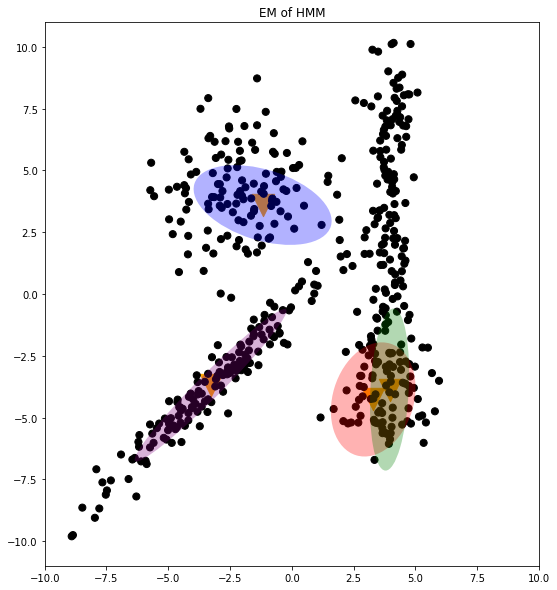

In [181]:
pi, A, centers, sigmas = EM(6)
plotEM(Y_t_data, centers, sigmas, "EM of HMM")

In [163]:
def compute_log_conditionals(Y_t_data, centers, sigmas, K=4):
    T = len(Y_t_data)
    log_p = np.zeros([T,K])
    multivar = dict()
    for k in range(K):
        m = scipy.stats.multivariate_normal(centers[k], sigmas[k])
        log_p[:,k] = np.log(m.pdf(Y_t_data))
    return log_p

In [164]:
## Viterbi algorithm
def viterbi(Y_t_data, log_pi, log_A, centers, sigmas): #Compute most probable sequence until T_end
    T_end = len(Y_t_data)
    log_p = compute_log_conditionals(Y_t_data, centers, sigmas)

    messages = np.zeros((T_end,K))
    messages[0,:] = log_pi + log_p[0,:]

    for t in range(1,T_end):
        vec = np.max(log_p[t,:].reshape(1,-1) + log_A + messages[t-1,:].reshape(-1,1), axis=0)
        messages[t,:] = vec

    most_probable_sequence = []

    most_probable_sequence.append(np.argmax(messages[T_end-1,:]))
    for t in range(2,T_end+1):
        tmp = log_p[T_end-t,:].reshape(1,-1) + log_A + messages[T_end-t+1,:].reshape(-1,1)
        vec = tmp[:,most_probable_sequence[-1]]
        i_realized_the_max = np.argmax(vec)
        
        most_probable_sequence.append(i_realized_the_max)
    
    return most_probable_sequence[::-1]

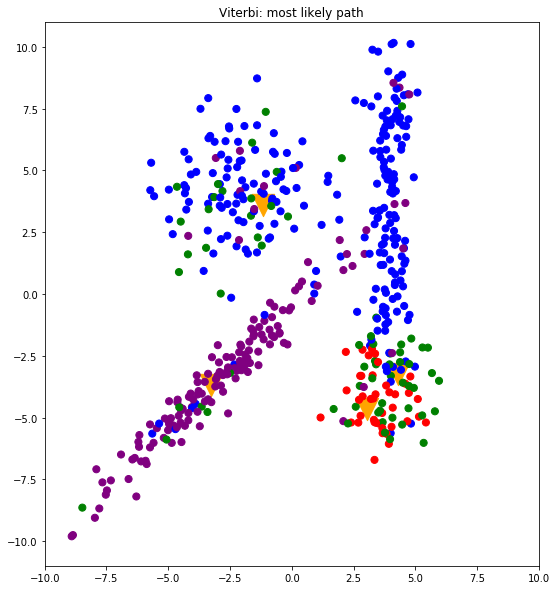

In [165]:
pi, A, centers, sigmas = EM(6)
q = viterbi(data['data'], np.log(pi), np.log(A), centers, sigmas)
plotEM(Y_t_data, centers, sigmas, "Viterbi: most likely path", q, display_ell=False)

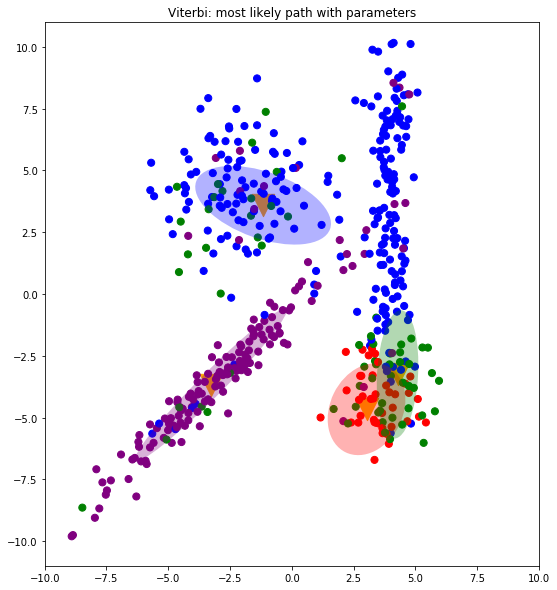

In [166]:
pi, A, centers, sigmas = EM(6)
q = viterbi(data['data'], np.log(pi), np.log(A), centers, sigmas)
plotEM(Y_t_data, centers, sigmas, "Viterbi: most likely path with parameters", q, display_ell=True)

In [23]:
def computeLL(Y, pi, A, centers, sigmas, z):
    llh = np.log(pi[z[0]])
    
    multivar = dict()
    for k in range(K):
        m = scipy.stats.multivariate_normal(centers[k], sigmas[k])
        multivar[k] = m
        
    for t in range(len(Y)-2):
        llh += np.log(multivar[z[t]].pdf(Y[t])) + np.log(A[z[t], z[t+1]])
    llh += np.log(multivar[z[len(Y)-1]].pdf(Y[len(Y)-1]))
    return llh    

In [31]:
llhdata = computeLL(data['data'], np.exp(log_pi), np.exp(log_A), centers, sigmas, q)
print("log likelihood for training data is", llhdata)
llhtest = computeLL(data['test'], np.exp(log_pi), np.exp(log_A), centers, sigmas, q)
print("log likelihood for test is", llhtest)

log likelihood for training data is -4645.605090779133
log likelihood for test is -10231.733345000705
